# Import thư viện

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import cv2
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten
from sklearn.metrics import make_scorer, accuracy_score
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import warnings
warnings.filterwarnings('ignore')

# Cài đặt YOLOv5

In [2]:
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17120, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 17120 (delta 47), reused 22 (delta 18), pack-reused 17043 (from 2)
Receiving objects: 100% (17120/17120), 15.78 MiB | 27.11 MiB/s, done.
Resolving deltas: 100% (11746/11746), done.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.8/906.8 kB 16.5 MB/s eta 0:00:00a 0:00:01


In [3]:
import yaml

# Đường dẫn tới file yaml trong dataset
yaml_path = '/kaggle/input/fruit-detection/Fruits-detection/data.yaml'

# Đọc file YAML gốc
with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)

# Chỉnh sửa đường dẫn
data['train'] = '/kaggle/input/fruit-detection/Fruits-detection/train/images'
data['val'] = '/kaggle/input/fruit-detection/Fruits-detection/valid/images'
data['test'] = '/kaggle/input/fruit-detection/Fruits-detection/test/images'

# Ghi lại file YAML mới
new_yaml_path = 'data.yaml'
with open(new_yaml_path, 'w') as f:
    yaml.dump(data, f)

print(f"Updated YAML saved to {new_yaml_path}")


Updated YAML saved to data.yaml


In [4]:
# Kiểm tra file YAML đã chỉnh sửa
with open('data.yaml', 'r') as f:  # 'data.yaml' là file đã lưu trong /kaggle/working/
    print(f.read())


names:
- Apple
- Banana
- Grape
- Orange
- Pineapple
- Watermelon
nc: 6
test: /kaggle/input/fruit-detection/Fruits-detection/test/images
train: /kaggle/input/fruit-detection/Fruits-detection/train/images
val: /kaggle/input/fruit-detection/Fruits-detection/valid/images



In [5]:
!yolo settings wandb=False

os.environ['WANDB_MODE'] = 'disabled'


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
JSONDict("/root/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/kaggle/working/yolov5/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "1bfc3e992d24318da58ddee183be5bf9388a31f26bab1738e986ec4d297417ff",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


# YOLOv5m

In [6]:
# Train model
!python train.py \
  --data data.yaml \
  --cfg yolov5m.yaml \
  --weights yolov5m.pt \
  --patience 10 \
  --img 224 \
  --epochs 50 \
  --project /kaggle/working/my_project \
  --name fruit-detection-m

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-01-12 09:56:03.788875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-12 09:56:03.810200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-12 09:56:03.816723: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m.pt, cfg=yolov5m.yaml, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=224, rect=False, resume=False, nosave=False, noval=False, noautoanchor=Fals

In [7]:
# Đánh giá trên validation set
!python val.py \
  --weights /kaggle/working/my_project/fruit-detection-m/weights/best.pt \
  --data data.yaml \
  --img 224 \
  --iou-thres 0.5 \
  --conf-thres 0.5

val: data=data.yaml, weights=['/kaggle/working/my_project/fruit-detection-m/weights/best.pt'], batch_size=32, imgsz=224, conf_thres=0.5, iou_thres=0.5, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.5 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-394-g86fd1ab2 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20873139 parameters, 0 gradients, 47.9 GFLOPs
val: Scanning /kaggle/input/fruit-detection/Fruits-detection/valid/labels... 914
val: WARNING ⚠️ /kaggle/input/fruit-detection/Fruits-detection/valid/images/3d3ddc3054b32eb7_jpg.rf.03e7789aaf5212e2634b84ef502e0832.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/fruit-detection/Fruits-detection/valid is not writeable: [Errno 30] Read-only 

# YOLOv5l

In [8]:
# Train model
!python train.py \
  --data data.yaml \
  --cfg yolov5l.yaml \
  --weights yolov5l.pt \
  --patience 10 \
  --img 224 \
  --epochs 50 \
  --project /kaggle/working/my_project \
  --name fruit-detection-l

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-01-12 11:26:49.651773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-12 11:26:49.674663: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-12 11:26:49.681706: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5l.pt, cfg=yolov5l.yaml, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=224, rect=False, resume=False, nosave=False, noval=False, noautoanchor=Fals

In [9]:
# Đánh giá trên validation set
!python val.py \
  --weights /kaggle/working/my_project/fruit-detection-l/weights/best.pt \
  --data data.yaml \
  --img 224 \
  --iou-thres 0.5 \
  --conf-thres 0.5

val: data=data.yaml, weights=['/kaggle/working/my_project/fruit-detection-l/weights/best.pt'], batch_size=32, imgsz=224, conf_thres=0.5, iou_thres=0.5, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.5 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-394-g86fd1ab2 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5l summary: 267 layers, 46135203 parameters, 0 gradients, 107.7 GFLOPs
val: Scanning /kaggle/input/fruit-detection/Fruits-detection/valid/labels... 914
val: WARNING ⚠️ /kaggle/input/fruit-detection/Fruits-detection/valid/images/3d3ddc3054b32eb7_jpg.rf.03e7789aaf5212e2634b84ef502e0832.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/fruit-detection/Fruits-detection/valid is not writeable: [Errno 30] Read-only

# YOLOv5x

In [10]:
# Train model
!python train.py \
  --data data.yaml \
  --cfg yolov5x.yaml \
  --weights yolov5x.pt \
  --patience 10 \
  --img 224 \
  --epochs 50 \
  --project /kaggle/working/my_project \
  --name fruit-detection-x

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-01-12 13:08:34.449543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-12 13:08:34.479005: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-12 13:08:34.487552: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5x.pt, cfg=yolov5x.yaml, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=224, rect=False, resume=False, nosave=False, noval=False, noautoanchor=Fals

In [11]:
# Đánh giá trên validation set
!python val.py \
  --weights /kaggle/working/my_project/fruit-detection-x/weights/best.pt \
  --data data.yaml \
  --img 224 \
  --iou-thres 0.5 \
  --conf-thres 0.5

val: data=data.yaml, weights=['/kaggle/working/my_project/fruit-detection-x/weights/best.pt'], batch_size=32, imgsz=224, conf_thres=0.5, iou_thres=0.5, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.5 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-394-g86fd1ab2 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86207059 parameters, 0 gradients, 203.9 GFLOPs
val: Scanning /kaggle/input/fruit-detection/Fruits-detection/valid/labels... 914
val: WARNING ⚠️ /kaggle/input/fruit-detection/Fruits-detection/valid/images/3d3ddc3054b32eb7_jpg.rf.03e7789aaf5212e2634b84ef502e0832.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/fruit-detection/Fruits-detection/valid is not writeable: [Errno 30] Read-only

# Demo với tập Test

In [15]:
!python detect.py \
  --weights /kaggle/working/my_project/fruit-detection-x/weights/best.pt \
  --img 224 \
  --source /kaggle/input/fruit-detection/Fruits-detection/test/images \
  --project /kaggle/working/modeloutput \
  --name detection-output \
  --save-txt

detect: weights=['/kaggle/working/my_project/fruit-detection-x/weights/best.pt'], source=/kaggle/input/fruit-detection/Fruits-detection/test/images, data=data/coco128.yaml, imgsz=[224, 224], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/kaggle/working/modeloutput, name=detection-output, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-394-g86fd1ab2 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86207059 parameters, 0 gradients, 203.9 GFLOPs
image 1/457 /kaggle/input/fruit-detection/Fruits-detection/test/images/000aee0af66d4237_jpg.rf.6b99256606e5b7a1ede8b833a87196a7.jpg: 224x224 1 Watermelon, 21.7ms
image 2/457 /kaggle/input/fruit-detection/Fruits-de

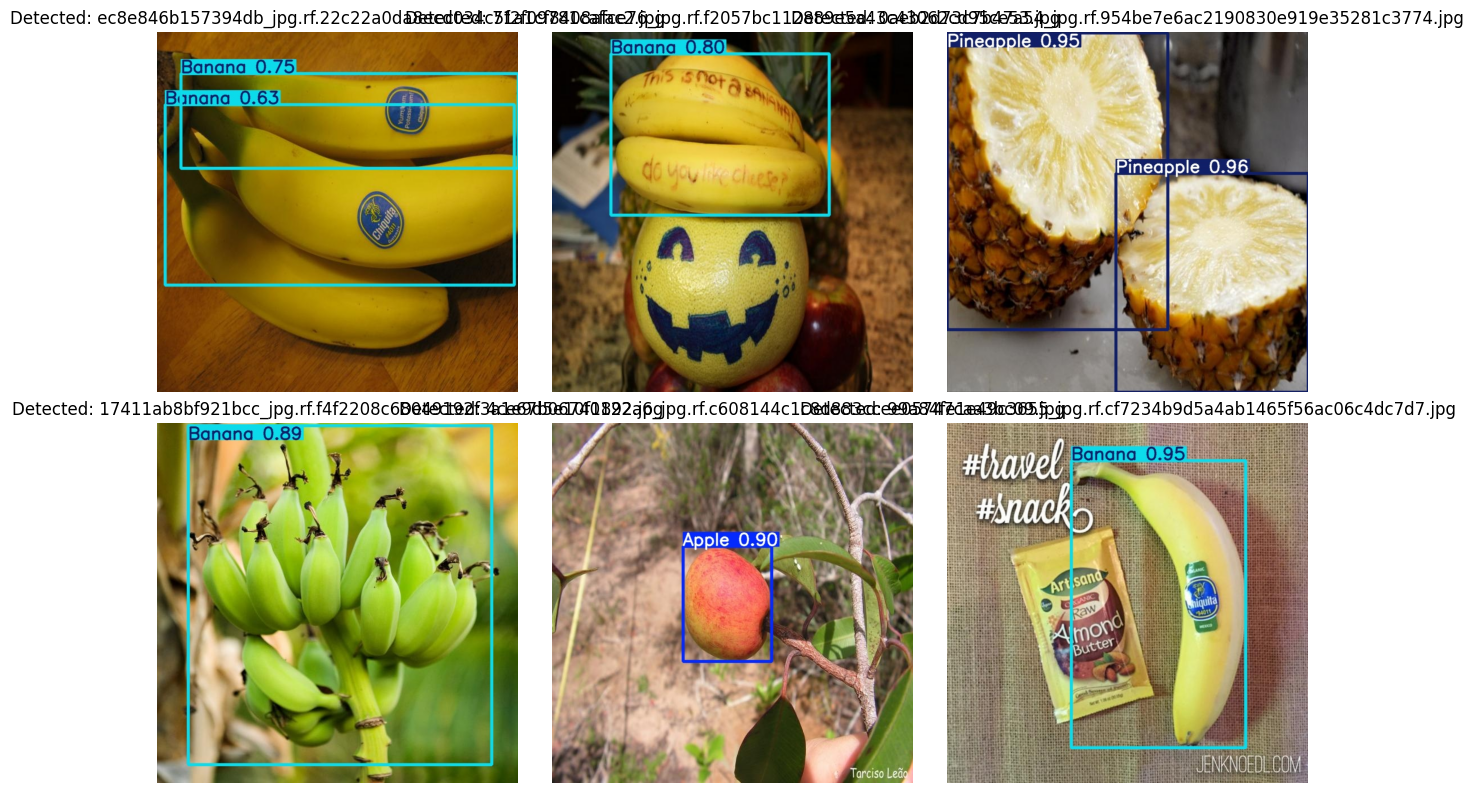

In [17]:
import cv2
import os
import matplotlib.pyplot as plt

# Đường dẫn tới thư mục chứa ảnh đã xử lý
output_dir = "/kaggle/working/modeloutput/detection-output2"

# Đọc các file ảnh trong thư mục đầu ra
image_files = [f for f in os.listdir(output_dir) if f.endswith('.jpg')]

def show_detected_images(image_files, output_dir):
    plt.figure(figsize=(12, 8))
    
    for i, image_file in enumerate(image_files[:6]): 
        image_path = os.path.join(output_dir, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển từ BGR sang RGB để hiển thị đúng

        # Hiển thị ảnh
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')

        # Hiển thị tiêu đề (nếu cần thiết)
        plt.title(f"Detected: {image_file}")

    plt.tight_layout()
    plt.show()

# Hiển thị các ảnh đã được phát hiện
show_detected_images(image_files, output_dir)

## Đánh giá mô hình trên tập Test

In [18]:
!python val.py \
--weights /kaggle/working/my_project/fruit-detection-x/weights/best.pt \
--data data.yaml \
--task test \
--img 224 \
--iou-thres 0.5 \
--conf-thres 0.5

val: data=data.yaml, weights=['/kaggle/working/my_project/fruit-detection-x/weights/best.pt'], batch_size=32, imgsz=224, conf_thres=0.5, iou_thres=0.5, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.5 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-394-g86fd1ab2 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86207059 parameters, 0 gradients, 203.9 GFLOPs
test: Scanning /kaggle/input/fruit-detection/Fruits-detection/test/labels... 457
test: WARNING ⚠️ Cache directory /kaggle/input/fruit-detection/Fruits-detection/test is not writeable: [Errno 30] Read-only file system: '/kaggle/input/fruit-detection/Fruits-detection/test/labels.cache.npy'
                 Class     Images  Instances          P          R      mAP50  